# 🌲 Random Forest Models for Drug Sensitivity Prediction

This notebook trains a **Random Forest (RF)** regression model per drug using gene expression features (PCA or HVGs). RFs are robust, handle nonlinearities, and offer good interpretability with minimal hyperparameter tuning. We use **5-fold cross-validation** to evaluate each model’s performance with RMSE and R² metrics.



In [4]:
import os
import joblib
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
NUM_PCS = 20

# Choose your dataset (PCA or HVG)
DATA_PATH = "../../../data/processed/bulk_with_pca_embeddings.parquet"
data = pd.read_parquet(DATA_PATH)

print("✅ Dataset loaded:", data.shape)


✅ Dataset loaded: (571985, 33)


### 🔁 Train One Random Forest Per Drug

For each drug, we train a separate RF model using its associated (cell line, IC50, features) data. We use train-test split and evaluate with RMSE and R².


In [6]:
os.makedirs("rf/models", exist_ok=True)
os.makedirs("rf/results", exist_ok=True)

non_features = ["SANGER_MODEL_ID", "DRUG_ID", "LN_IC50"]
gene_cols = [col for col in data.columns if col not in non_features]

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

results = []

for drug_id in sorted(data["DRUG_ID"].unique()):
    df = data[data["DRUG_ID"] == drug_id].dropna(subset=["LN_IC50"])
    if df.shape[0] < 10:
        print(f"⚠️ Skipped drug {drug_id} (samples: {df.shape[0]})")
        continue

    X = df[gene_cols].values.astype("float64")
    y = df["LN_IC50"].values.astype("float64")

    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        n_jobs=-1,
        random_state=42
    )

    rmse_scores = cross_val_score(model, X, y, cv=kf, scoring=rmse_scorer)
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring="r2")

    print(f"\n🌲 Drug {drug_id} | Samples: {len(df)}")
    print(f"  ➤ RMSE (folds): {(-rmse_scores).round(4)} | Mean: {-rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}")
    print(f"  ➤ R²   (folds): {r2_scores.round(4)} | Mean: {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")

    results.append({
        "DRUG_ID": drug_id,
        "n_samples": len(df),
        "rmse_mean": -rmse_scores.mean(),
        "rmse_std": rmse_scores.std(),
        "r2_mean": r2_scores.mean(),
        "r2_std": r2_scores.std()
    })

    model.fit(X, y)
    #joblib.dump(model, f"rf/models/rf_drug_{drug_id}.pkl")



🌲 Drug 1 | Samples: 391
  ➤ RMSE (folds): [1.3316 0.8686 1.1438 1.1493 1.1412] | Mean: 1.1269 ± 0.1481
  ➤ R²   (folds): [ 0.0426 -0.0689  0.028  -0.1481 -0.2558] | Mean: -0.0805 ± 0.1117

🌲 Drug 3 | Samples: 356
  ➤ RMSE (folds): [2.1031 1.9617 2.0615 2.0882 2.2038] | Mean: 2.0837 ± 0.0777
  ➤ R²   (folds): [-0.2208 -0.1317 -0.0492 -0.0379 -0.0386] | Mean: -0.0956 ± 0.0717

🌲 Drug 5 | Samples: 394
  ➤ RMSE (folds): [1.4506 1.4402 1.8935 1.6127 1.4174] | Mean: 1.5629 ± 0.1792
  ➤ R²   (folds): [ 0.1949  0.1923  0.0863 -0.1021 -0.0475] | Mean: 0.0648 ± 0.1217

🌲 Drug 6 | Samples: 403
  ➤ RMSE (folds): [1.1337 0.7817 0.9279 0.8539 0.9254] | Mean: 0.9245 ± 0.1176
  ➤ R²   (folds): [-0.0751 -0.1392 -0.0156 -0.2972 -0.0538] | Mean: -0.1162 ± 0.0990

🌲 Drug 9 | Samples: 396
  ➤ RMSE (folds): [1.5246 1.4729 1.3932 1.5144 1.374 ] | Mean: 1.4558 ± 0.0618
  ➤ R²   (folds): [ 0.0114 -0.0206 -0.0229  0.0082  0.0551] | Mean: 0.0062 ± 0.0282

🌲 Drug 11 | Samples: 393
  ➤ RMSE (folds): [1.8759 1.911

KeyboardInterrupt: 

In [ ]:
results_df = pd.DataFrame(results)
results_df.to_csv(f"rf/results/teste.csv", index=False)

print("📁 Saved to rf/results/model_performance_summary.csv")
results_df.head()


📁 Saved to rf/results/model_performance_summary.csv


,DRUG_ID,n_samples,rmse_mean,rmse_std,r2_mean,r2_std
0,1,384,1.067280,0.098944,0.048687,0.144814
1,3,350,1.974195,0.132728,0.001011,0.088847
2,5,387,1.517251,0.142814,0.143247,0.069339
3,6,396,0.906869,0.138042,-0.065314,0.036172
4,9,390,1.426702,0.099928,0.027000,0.031591


### 📊 Distribution of RF Model Performance
We now visualize the RMSE and R² scores to analyze how well the RF models performed across all drugs.


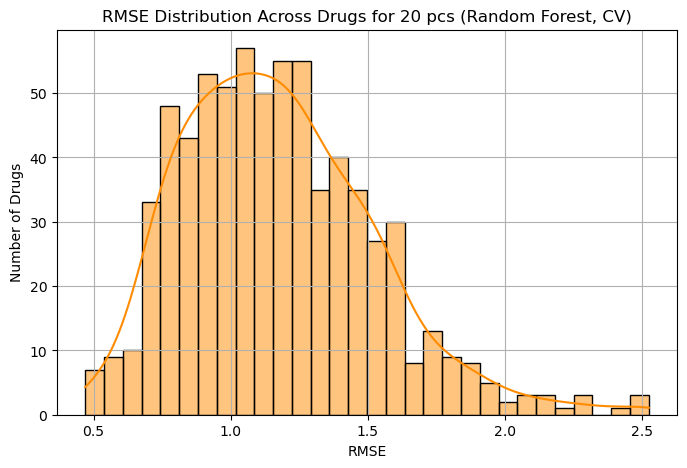

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(results_df["rmse_mean"], kde=True, bins=30, color="darkorange")
plt.title(f"RMSE Distribution Across Drugs for {NUM_PCS} pcs (Random Forest, CV)")
plt.xlabel("RMSE")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.show()
plt.close()

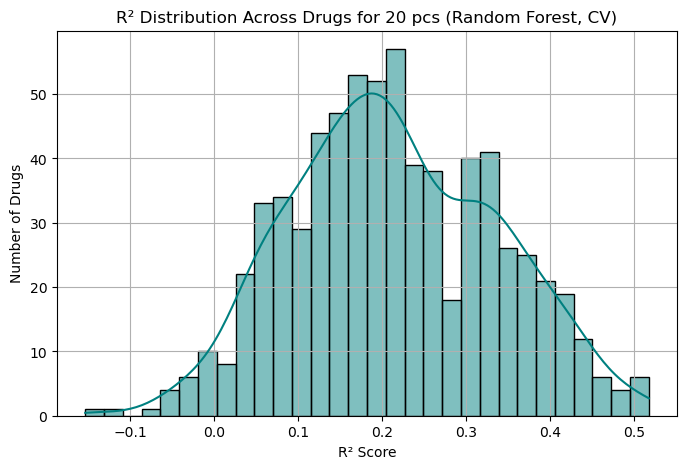

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(results_df["r2_mean"], kde=True, bins=30, color="teal")
plt.title(f"R² Distribution Across Drugs for {NUM_PCS} pcs (Random Forest, CV)")
plt.xlabel("R² Score")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.show()
plt.close()

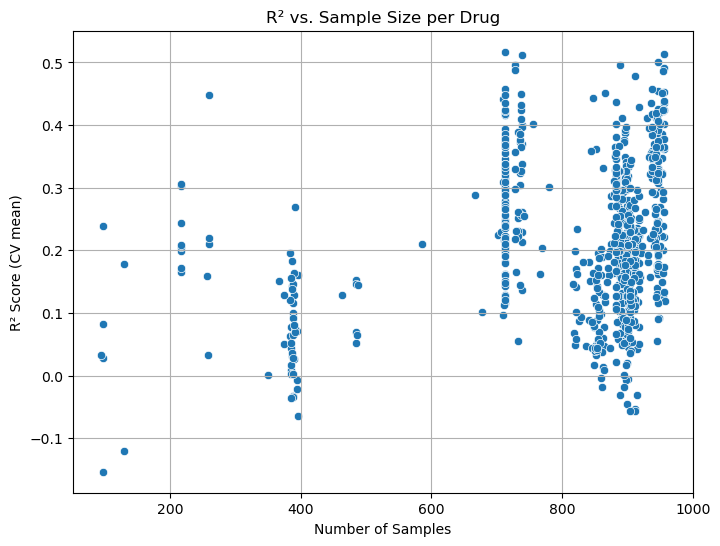

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x="n_samples", y="r2_mean", data=results_df)
plt.title("R² vs. Sample Size per Drug")
plt.xlabel("Number of Samples")
plt.ylabel("R² Score (CV mean)")
plt.grid(True)
plt.show()


In [ ]:
from scipy.stats import pearsonr, spearmanr

# Pearson (linear)
pearson_corr, pval_pearson = pearsonr(results_df["n_samples"], results_df["r2_mean"])
print(f"📊 Pearson r = {pearson_corr:.3f} (p = {pval_pearson:.3g})")

# Spearman (rank-based, robust to non-linearities)
spearman_corr, pval_spearman = spearmanr(results_df["n_samples"], results_df["r2_mean"])
print(f"📊 Spearman ρ = {spearman_corr:.3f} (p = {pval_spearman:.3g})")


📊 Pearson r = 0.237 (p = 2.17e-10)
📊 Spearman ρ = 0.212 (p = 1.51e-08)


Text(0.5, 1.0, 'R² vs. IC50 Variance')

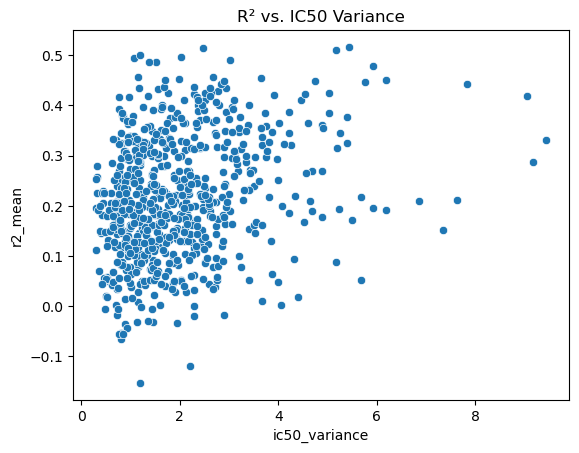

In [ ]:
variances = data.groupby("DRUG_ID")["LN_IC50"].var()
results_df = results_df.merge(variances.rename("ic50_variance"), on="DRUG_ID")
sns.scatterplot(data=results_df, x="ic50_variance", y="r2_mean")
plt.title("R² vs. IC50 Variance")
